In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import json
import matplotlib.pyplot as plt

# Importing keras from tensorflow
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, GRU, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


import LSTM as lstm_impl
import CNN_LSTM as cnn_lstm_impl
import utils as model_utils
import transformer as tr_impl

In [14]:
raw_data, features_df, labels_dict = model_utils.get_aligned_raw_feat_lbl()

print('label keys: ', labels_dict.keys())

[*********************100%%**********************]  1 of 1 completed
label keys:  dict_keys(['ct_two_state', 'ct_three_state', 'fixed_time_horizon', 'oracle', 'triple_barrier'])


In [15]:
print('Raw data shape:', raw_data.shape)
print('Features shape:', features_df.shape)
print('Labels shape:', labels_dict['ct_two_state'].shape)

Raw data shape: (3612, 6)
Features shape: (3612, 33)
Labels shape: (3612,)


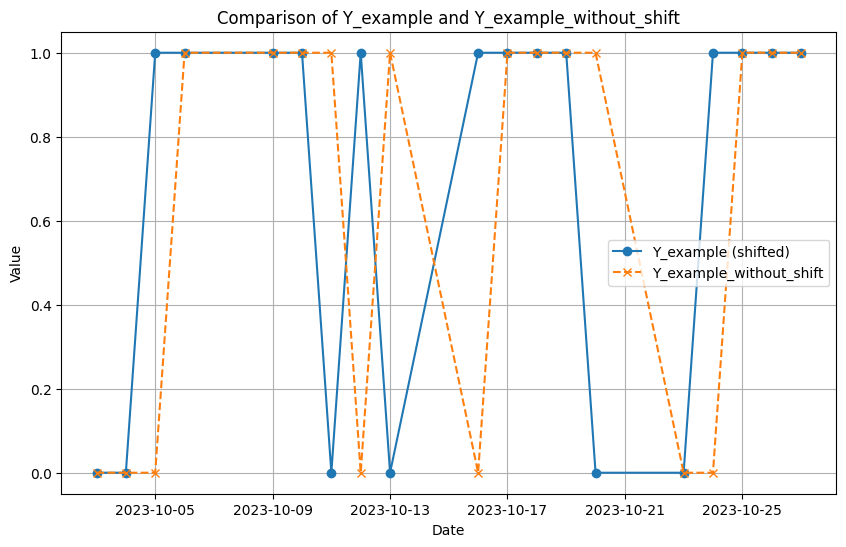

In [16]:
labels_example = labels_dict['ct_two_state'][-20:]
Y_example = labels_example.shift(-1)[:-1].astype(int)
Y_example_without_shift = labels_example[:-1].astype(int)

# Plotting the series
plt.figure(figsize=(10, 6))
plt.plot(Y_example, label='Y_example (shifted)', marker='o')
plt.plot(Y_example_without_shift, label='Y_example_without_shift', marker='x', linestyle='--')
plt.title('Comparison of Y_example and Y_example_without_shift')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
def get_X(data, window_size):
    # Normalize features to range between -1 and 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data.values)

    # Create the 3D input data shape [samples, time_steps, features] and retain dates
    X = []
    dates = []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i, :].flatten())
        dates.append(data.index[i])

    # Convert to a DataFrame
    X_df = pd.DataFrame(X, index=dates)

    return X_df

def get_Y(labels: pd.Series, window_size):
    return labels[window_size:]

window_size = 60
example_X = get_X(raw_data, window_size)
example_Y = get_Y(labels_dict['ct_two_state'], window_size)


print('example_X - start end dates:', example_X.index[0], example_X.index[-1])
print('example_Y - start end dates:', example_Y.index[0], example_Y.index[-1])

example_X - start end dates: 2009-09-16 00:00:00 2023-10-30 00:00:00
example_Y - start end dates: 2009-09-16 00:00:00 2023-10-30 00:00:00


In [18]:
window_size = 60
raw_X = model_utils.get_X(raw_data, window_size)
raw_Y_dict = {key: model_utils.get_Y(series, window_size) for key, series in labels_dict.items()}
feat_X = model_utils.get_X(features_df, 1)[window_size-1:]
feat_Y_dict = {key: model_utils.get_Y(series, 1)[window_size-1:] for key, series in labels_dict.items()}

raw_X_train, raw_X_val, feat_X_train, feat_X_val = train_test_split(raw_X, feat_X, test_size=0.2, shuffle=False)
raw_Y_train_dict, raw_Y_val_dict, feat_Y_train_dict, feat_Y_val_dict = {}, {}, {}, {}
for key in raw_Y_dict.keys():
    raw_Y_train_dict[key], raw_Y_val_dict[key], feat_Y_train_dict[key], feat_Y_val_dict[key] = train_test_split(raw_Y_dict[key], feat_Y_dict[key], test_size=0.2, shuffle=False)

raw_X_val, raw_X_test, feat_X_val, feat_X_test = train_test_split(raw_X_val, feat_X_val, test_size=0.25, shuffle=False)
raw_Y_test_dict, feat_Y_test_dict = {}, {}
for key in raw_Y_val_dict.keys():
    raw_Y_val_dict[key], raw_Y_test_dict[key], feat_Y_val_dict[key], feat_Y_test_dict[key] = train_test_split(raw_Y_val_dict[key], feat_Y_val_dict[key], test_size=0.25, shuffle=False)

print('Raw X train shape:', raw_X_train.shape)
print('Raw X val shape:', raw_X_val.shape)
print('Raw X test shape:', raw_X_test.shape)
print('Raw Y train shape:', raw_Y_train_dict['ct_two_state'].shape)
print('Raw Y val shape:', raw_Y_val_dict['ct_two_state'].shape)
print('Raw Y test shape:', raw_Y_test_dict['ct_two_state'].shape)
print()
print('Features X train shape:', feat_X_train.shape)
print('Features X val shape:', feat_X_val.shape)
print('Features X test shape:', feat_X_test.shape)
print('Features Y train shape:', feat_Y_train_dict['ct_two_state'].shape)
print('Features Y val shape:', feat_Y_val_dict['ct_two_state'].shape)
print('Features Y test shape:', feat_Y_test_dict['ct_two_state'].shape)

Raw X train shape: (2841, 60, 6)
Raw X val shape: (533, 60, 6)
Raw X test shape: (178, 60, 6)
Raw Y train shape: (2841, 1)
Raw Y val shape: (533, 1)
Raw Y test shape: (178, 1)

Features X train shape: (2841, 1, 33)
Features X val shape: (533, 1, 33)
Features X test shape: (178, 1, 33)
Features Y train shape: (2841, 1)
Features Y val shape: (533, 1)
Features Y test shape: (178, 1)


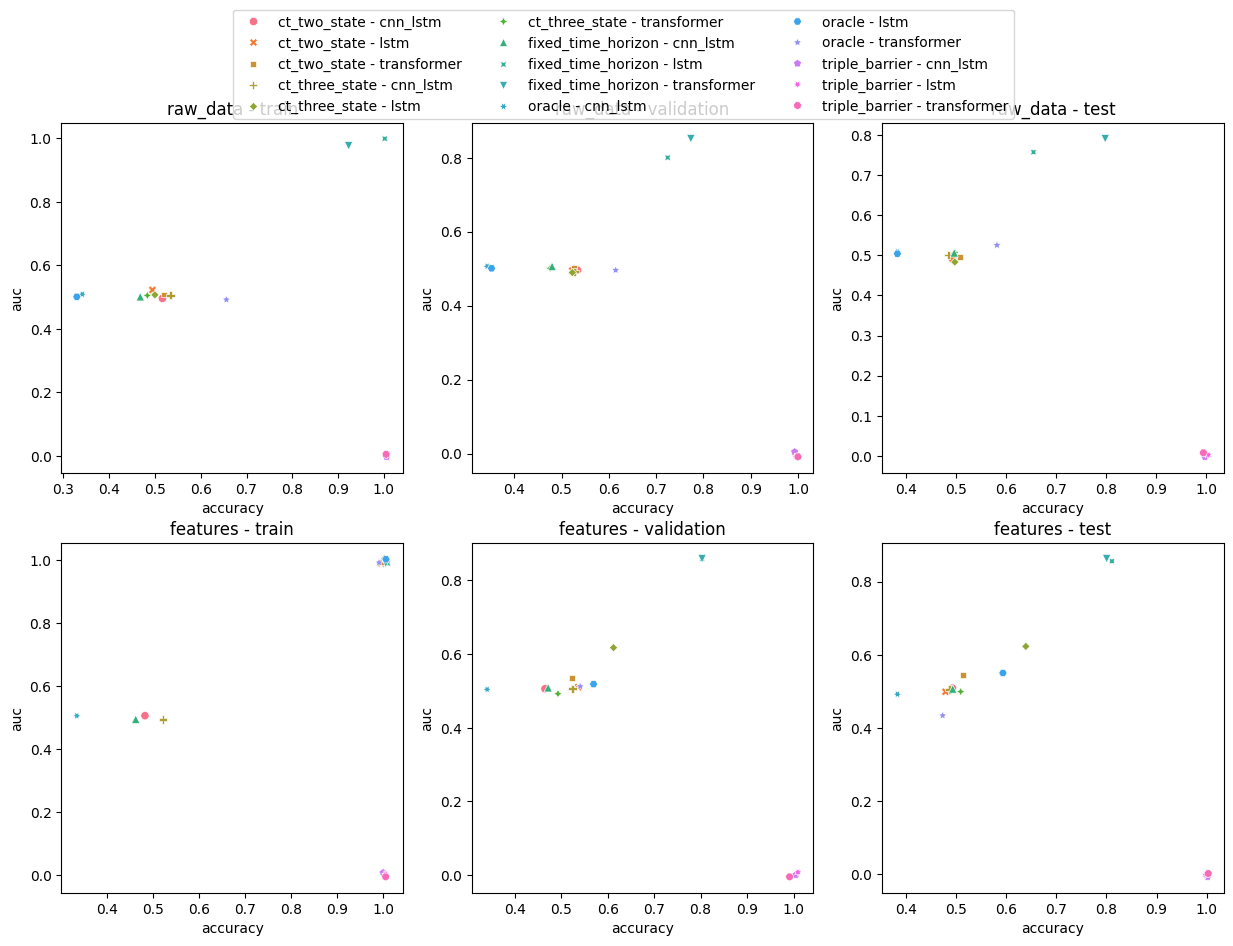

In [19]:
metrics_df = model_utils.plot_acc_auc('test_logs/test1/metrics.json')

In [20]:
filtered_df = metrics_df[
    (metrics_df['accuracy'] > 0.7) & (metrics_df['accuracy'] <= 1.1) &
    (metrics_df['auc'] > 0.7) & (metrics_df['auc'] <= 1.1)
]

print(filtered_df[['features_used', 'model_name', 'labeling_algorithm']].drop_duplicates())

   features_used   model_name  labeling_algorithm
21      raw_data         lstm  fixed_time_horizon
24      raw_data  transformer  fixed_time_horizon
48      features         lstm        ct_two_state
51      features  transformer        ct_two_state
57      features         lstm      ct_three_state
60      features  transformer      ct_three_state
66      features         lstm  fixed_time_horizon
69      features  transformer  fixed_time_horizon
75      features         lstm              oracle
78      features  transformer              oracle
